# PART2
General Imports  

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns 
from sklearn.decomposition import PCA

Data Loading and simple preprocessing

In [3]:
v1 = pd.read_csv("integrated2.csv")
v1 = v1.drop(columns=['Unnamed: 0' , "geometry" , "CNT_FULLNAME"])
v1

,lat,lon,PSurf1,PSurf10,PSurf11,PSurf12,PSurf13,PSurf14,PSurf15,PSurf16,...,CEC topsoil,CEC subsoil,CEC clay topsoil,CEC Clay subsoil,CaCO3 % topsoil,CaCO3 % subsoil,BD topsoil,BD subsoil,C/N topsoil,C/N subsoil
0,-8.25,27.25,89931.291146,89935.560190,89857.437607,89719.336024,89919.630089,89795.942393,89822.866530,89845.084958,...,12.58,11.94,57.1,46.8,5.46,7.82,1.38,1.37,9.8,9.9
1,-8.25,27.75,88198.302755,88202.255054,88144.626482,88011.359357,88205.834726,88097.959524,88101.279536,88143.110607,...,9.98,10.31,57.8,44.8,18.23,26.54,1.48,1.43,10.3,10.8
2,-8.25,28.25,89235.961901,89234.871446,89175.960774,89039.490220,89237.955708,89145.462488,89148.886125,89189.423988,...,9.98,10.31,57.8,44.8,18.23,26.54,1.48,1.43,10.3,10.8
3,-8.25,28.75,89689.187172,89694.181381,89638.232685,89500.870935,89700.801429,89613.034661,89615.432875,89656.726643,...,10.87,10.06,56.7,45.8,8.54,11.32,1.42,1.38,10.3,10.8
4,-7.75,27.25,93016.242297,93018.701482,92912.807863,92766.109494,92984.016548,92840.870970,92899.681970,92893.402655,...,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,10.75,24.25,95072.465089,94959.076833,94828.393851,94597.915542,94820.357179,94638.193423,94533.842458,94701.787935,...,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0
585,11.25,23.25,94380.135922,94266.675756,94140.533315,93925.996935,94145.756238,93967.888226,93894.973268,94048.788238,...,5.20,4.00,27.5,14.0,0.05,0.25,0.60,0.75,5.5,4.0
586,11.25,23.75,94442.190333,94333.525786,94204.438512,93982.367929,94202.245667,94021.829244,93923.329673,94090.795161,...,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0
587,11.25,24.25,94815.380714,94705.219577,94574.246238,94340.447714,94563.048720,94380.986940,94259.847762,94441.106321,...,8.70,7.90,66.0,50.0,13.10,22.10,1.50,1.40,8.0,11.0


Since the goal is to build clusters and not extracting information from the dataset  we can remove the high correlated data from the dataframe like subSoil / topSoil correlated data  (for the integrated2 dataset)

In [4]:
v1 = v1.drop(columns=['sand % subsoil','silt% subsoil', 'clay % subsoil', 'pH water subsoil','N % subsoil',
        'BS % subsoil','CEC subsoil', 'CEC Clay subsoil','CaCO3 % subsoil',  'BD subsoil'])

We also drop the correlated top soil chimical components (integrated 2)

In [5]:
v1 = v1.drop(columns= ['BS % topsoil','BD topsoil'])
for i in range(2 , 53):
    v1 = v1.drop(columns=[f"PSurf{i}"])

In [6]:
def replace_outliers_iqr(df):
    df_modified = df.copy()
    
    for column in df_modified.columns:
        if df_modified[column].dtype in [int, float]:
            # Calculate Q1 (25th percentile) and Q3 (75th percentile)
            Q1 = df_modified[column].quantile(0.25)
            Q3 = df_modified[column].quantile(0.75)
            IQR = Q3 - Q1  # Calculate the IQR
            
            # Determine the lower and upper bounds for outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Replace outliers with lower IQR for values below the lower bound
            df_modified[column] = df_modified[column].where(df_modified[column] >= lower_bound, Q1)
            
            # Replace outliers with upper IQR for values above the upper bound
            df_modified[column] = df_modified[column].where(df_modified[column] <= upper_bound, Q3)
    
    return df_modified

In [7]:
v1 = replace_outliers_iqr(v1)

Normlize the data for better distance calculation

In [ ]:
# usin the previous part normalization function 
def MinMax_Normalization(df):
    df_minmax = pd.DataFrame()
    for column in df.columns:
        if df[column].dtype == 'float64' and column not in ["lat","lon"]:
            bas = min(df[column])
            haut = max(df[column])
            gap = haut - bas
            df_minmax[column] = (df[column] - bas)/gap
    return df_minmax

v1 = MinMax_Normalization(v1)

In [9]:
v1

,PSurf1,Qair1,Qair10,Qair11,Qair12,Qair13,Qair14,Qair15,Qair16,Qair17,...,clay % topsoil,pH water topsoil,OC % topsoil,OC % subsoil,N % topsoil,CEC topsoil,CEC clay topsoil,CaCO3 % topsoil,C/N topsoil,C/N subsoil
0,0.539899,0.873389,0.863076,0.860435,0.868676,0.863788,0.832848,0.849695,0.784988,0.651386,...,0.366788,0.749740,0.430258,0.452830,0.278761,0.459627,0.758300,0.225620,0.471154,0.61875
1,0.432369,0.813374,0.807471,0.815513,0.820471,0.805804,0.786947,0.770664,0.729872,0.513402,...,0.316689,0.817238,0.369742,0.388140,0.265487,0.364633,0.767596,0.753306,0.495192,0.67500
2,0.496754,0.854972,0.837554,0.848007,0.860277,0.851238,0.839111,0.854447,0.797057,0.595165,...,0.316689,0.817238,0.369742,0.388140,0.265487,0.364633,0.767596,0.753306,0.495192,0.67500
3,0.524877,0.853749,0.845747,0.860601,0.870127,0.869074,0.861633,0.889331,0.827518,0.673923,...,0.407764,0.767394,0.500369,0.545822,0.500000,0.397150,0.752988,0.352893,0.495192,0.67500
4,0.731317,0.967563,0.936015,0.942309,0.958357,0.953938,0.907466,0.967658,0.888858,0.842927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,0.858904,0.016068,0.012089,0.013392,0.012723,0.014246,0.008447,0.280849,0.046233,0.462900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
585,0.815946,0.009515,0.008479,0.005911,0.005692,0.016600,0.002460,0.160712,0.016689,0.462900,...,0.206536,0.368640,0.357934,0.269542,0.287611,0.189989,0.365206,0.002066,0.264423,0.25000
586,0.819796,0.004089,0.001850,0.000000,0.000000,0.000000,0.000000,0.150488,0.000000,0.462900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
587,0.842952,0.013870,0.006920,0.004735,0.006676,0.007048,0.007971,0.192196,0.001469,0.462900,...,0.411413,0.799585,0.243542,0.309973,0.442478,0.317866,0.876494,0.541322,0.384615,0.68750


Since none of the algorithme we will use is influenced by the presence of outliers we w'ont handle them

In [10]:
v1.to_csv("final.csv")

# 2. algorithmes coding

1.1 Decision Tree

In [10]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def calculate_mse(data, target):
    return ((data[target] - data[target].mean()) ** 2).mean()

def features_2_dict(df):
    return {feature: df.columns.get_loc(feature) for feature in df.columns}

def end_criterion(df, depth, max_depth):
    return len(df) < 2 or depth >= max_depth

def find_best_feature_and_threshold(df, target):
    best_feature = None
    best_threshold = None
    best_score = float("inf")

    features = [col for col in df.columns if col != target]

    for feature in features:
        thresholds = df[feature].unique()
        thresholds.sort()

        for i in range(1, len(thresholds)):
            threshold = (thresholds[i] + thresholds[i - 1]) / 2

            left_data = df[df[feature] <= threshold]
            right_data = df[df[feature] > threshold]

            if len(left_data) == 0 or len(right_data) == 0:
                continue

            mse_left = calculate_mse(left_data, target)
            mse_right = calculate_mse(right_data, target)
            score = (len(left_data) * mse_left + len(right_data) * mse_right) / len(df)

            if score < best_score:
                best_feature = feature
                best_threshold = threshold
                best_score = score

    return best_feature, best_threshold, best_score

def split(df, feature, threshold):
    left_df = df[df[feature] <= threshold]
    right_df = df[df[feature] > threshold]
    return left_df, right_df

def leaf_value(df, target):
    return df[target].mean()

def build_tree(df, target='Rainf1', depth=0, max_depth=200, min_impurity=2):
    if end_criterion(df, depth, max_depth):
        return Node(value=leaf_value(df, target))

    impurity = calculate_mse(df, target)
    best_feature, best_threshold, weighted_impurity = find_best_feature_and_threshold(df, target)

    if (weighted_impurity / impurity) * 100 < min_impurity:
        return Node(value=leaf_value(df, target))

    left_son, right_son = split(df, best_feature, best_threshold)

    return Node(
        feature=best_feature,
        threshold=best_threshold,
        left=build_tree(left_son, target, depth + 1, max_depth, min_impurity),
        right=build_tree(right_son, target, depth + 1, max_depth, min_impurity),
    )

def predict(root, line, features_indexes_dict):
    if root.left is None and root.right is None:
        return root.value

    feature_index = features_indexes_dict[root.feature]
    if line[feature_index] < root.threshold:
        return predict(root.left, line, features_indexes_dict)
    else:
        return predict(root.right, line, features_indexes_dict)

def fit(df, test_data_percent=20, target='Rainf1', max_depth=5, min_impurity=2):
    len_test = int(len(df) * test_data_percent / 100)
    train_data = df.iloc[:-len_test]
    test_data = df.iloc[-len_test:]

    root = build_tree(train_data, target, max_depth=max_depth, min_impurity=min_impurity)

    features_indexes = features_2_dict(df)
    predicted = [predict(root, line, features_indexes) for _, line in test_data.iterrows()]

    predicted = pd.Series(predicted, index=test_data.index)
    mse = ((test_data[target] - predicted) ** 2).mean()
    r_square = r2_score(test_data[target], predicted)
    mae = mean_absolute_error(test_data[target], predicted)
    rmse = root_mean_squared_error(test_data[target], predicted)

    return root, mse, r_square, mae, rmse

def r2_score(y_true, y_pred):
    ss_res = ((y_true - y_pred) ** 2).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    return 1 - (ss_res / ss_tot)

def mean_absolute_error(y_true, y_pred):
    return abs(y_true - y_pred).mean()

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

root, mse, r_square, mae, rmse = fit(v1, 80, 'Qair1', max_depth=3)
print(f"MSE: {mse}, R^2: {r_square}, MAE: {mae}, RMSE: {rmse}")

MSE: 0.07249883473140549, R^2: -0.1595933204164639, MAE: 0.21153292791335548, RMSE: 0.2692560764985732


C:\Users\abdo7\AppData\Local\Temp\ipykernel_14080\1812494760.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if line[feature_index] < root.threshold:


2.1 Random Forest

In [ ]:
def create_sample(df, max_features, target = 'Rainf1', bootstrap_percent = 60):
    """
    Create a random sample of the dataframe with specified features and bootstrap percentage.
    """
    sampled_features = np.random.choice(df.columns.difference([target]), max_features, replace=False)  # Exclude target
    sampled_df = df[list(sampled_features) + [target]].sample(
        frac=bootstrap_percent / 100, replace=True, random_state=None
    )
    return sampled_df

def Random_forest(df, nbr_trees=10, max_features=150, bootstrap_percent=60,
                  test_data_percent=20, target='Rainf1', max_depth=5, min_impurity=2):
    """
    Build a random forest by training multiple decision trees on bootstrapped samples of the data.
    """
    forest = []
    errors = []

    for i in range(nbr_trees):
        # Create random sampling
        df_sample = create_sample(df, max_features, target, bootstrap_percent)
        print(f"Sample created with features: {len(df_sample.columns) - 1} // rows: {len(df_sample)}")

        # Train a decision tree
        tree, mse, _, _, _ = fit(df_sample, test_data_percent, target, max_depth=max_depth, min_impurity=min_impurity)
        print(f"Tree {i} successfully created, mse = {mse:.4f}")

        # Store the tree and its error
        forest.append(tree)
        errors.append(mse)

    print("Forest complete!")
    return forest, errors

def RF_predict(forest, line, features_indexes):
    """
    Predict the output for a single line using the Random Forest ensemble.
    """
    predictions = np.array([predict(tree, line, features_indexes) for tree in forest])
    return predictions.mean()

def train_test_sets(df, test_data_percent):
    """
    Split the data into train and test sets based on the specified percentage.
    """
    len_test = int(len(df) * test_data_percent / 100)
    train_data = df[:-len_test]
    test_data = df[-len_test:]
    return train_data, test_data

def evaluate_rf(forest, df, target, test_data_percent=20):
    """
    Evaluate the Random Forest model on the test data.
    """
    # Split data
    _, test_data = train_test_sets(df, test_data_percent)

    # Generate feature indexes
    features_indexes = features_2_dict(df)

    # Predict values for test data
    predicted = np.array([RF_predict(forest, line, features_indexes) for _, line in test_data.iterrows()])

    # Actual target values
    y_true = test_data[target].values

    # Calculate metrics
    mse = np.mean((y_true - predicted) ** 2)
    r2 = 1 - mse / np.var(y_true)

    return mse, r2

# Main code
forest, mse_list = Random_forest(v1, nbr_trees=10, max_features=150, bootstrap_percent=60,
                                  test_data_percent=20, target='Rainf1', max_depth=5, min_impurity=2)

print("\n~~~~~~~~~~ Evaluation Part ~~~~~~~~~~\n")
print(f"Mean of MSE values of all trees: {np.mean(mse_list):.4f}\n")

mse, r2 = evaluate_rf(forest, v1, target='Rainf1', test_data_percent=20)
print(f"Overall Random Forest Evaluation:\nMSE: {mse:.4f}, R^2: {r2:.4f}\n")

# Single Prediction Test
print("\n~~~~~~~~~~ Prediction Test ~~~~~~~~~~\n")
line_as_df = v1.sample(1)
print(line_as_df.columns)
line = line_as_df.iloc[0]
my_dict = features_2_dict(v1)
prediction = RF_predict(forest, line, my_dict)

print(f"Prediction: {prediction:.4f}\nActual: {line_as_df['Rainf1'].values[0]:.4f}\n")

1.1 CLARANS algorithme

In [9]:
import numpy as np
import pandas as pd

def hamming(arr1, arr2):
    return np.sum(arr1 != arr2)

def manhattan(atr1, atr2):
    return np.abs(atr1 - atr2)

def distance(row, medoid):
    dist = 0
    for col in row.index:
        if col not in ["cluster", "distance"]:
            if row[col].dtype == "object":
                dist += (row[col] != medoid[col])
            else:
                dist += np.abs(row[col] - medoid[col])
    return dist

def affect_clusters(df, medoids):
    distances = np.zeros((len(df), len(medoids)))
    for j in range(len(medoids)):
        distances[:, j] = df.apply(lambda row: distance(row, medoids.iloc[j]), axis=1)
    clusters = np.argmin(distances, axis=1)
    return clusters

def global_distances(df, medoids):
    df['distance'] = np.zeros(len(df))
    for i in range(len(df)):
        cluster_index = int(df.iloc[i]["cluster"])
        if cluster_index < len(medoids):
            df.at[i, "distance"] = distance(df.iloc[i], medoids.iloc[cluster_index])
        else:
            print(f"Warning: cluster index {cluster_index} is out of bounds for medoids.")
    return df

def medoids_change_test(df, max_neighbor, nbr_clusters, medoids):
    for _ in range(max_neighbor): 
        for j in range(nbr_clusters):
            df_test = df[df["cluster"] == j]
            current_distance = df_test["distance"].sum()
            #print(f"Cluster {j} ---> Current distance: {current_distance}")

            # randomly select another medoid
            if not df_test.empty: 
                med = df_test.sample(n=1).reset_index(drop=True)
                new_meds = medoids.copy()
                new_meds.loc[j] = med.iloc[0]

                # calculate distances with new medoid
                df_test_updated = global_distances(df_test, new_meds)
                second_distance = df_test_updated["distance"].sum()

                #print(f"New medoid for cluster {j}: {new_meds.iloc[j]}")
                print(f"Second distance ---> {second_distance}")

                if second_distance < current_distance: 
                    medoids.loc[j] = new_meds.loc[j]
                    #print(f"Medoid for cluster {j} updated.")

    return medoids

def Clarans(v1, nbr_clusters, max_neighbor, numlocal):
    loop = 0
    min_distance = float("inf")
    global_meds = None
    df = v1.copy()

    while loop < numlocal: 
        # Randomly select medoids
        medoids = df.sample(n=nbr_clusters).reset_index(drop=True)
        print("Medoids are set")

        # Calculate distances and affect cluster number
        df["cluster"] = affect_clusters(df, medoids)
        print("Clusters are set")
        
        df = global_distances(df, medoids)
        print("Global distances added")

        # Update medoids based on the distance change test
        medoids = medoids_change_test(df, max_neighbor, nbr_clusters, medoids)

        current_distance = df["distance"].sum()
        if current_distance < min_distance: 
            print("Meds changed")
            global_meds = medoids
            min_distance = current_distance  # Update minimum distance

        print("Done")
        loop += 1

    return df, global_meds

In [ ]:
df_clarans , meds = Clarans(v1 , 4 , 10, 1)
df_clarans

1.2 Generate results file 

In [ ]:
from sklearn.metrics import silhouette_score
# array_of_tests
nbr_clusters = [2 , 5 , 10 , 20 , 50 , 100]
nbr_neighbor = [2 , 5 , 10 , 20 , 50 , 100]
nbr_local = [1 , 4 , 8 , 10 , 20]
for num_local in nbr_local : 
    for i in nbr_clusters:
        for j in nbr_clusters:
            result , meds = Clarans(v1 , i , j , num_local)
            result = global_distances(result , meds)
            distances = result["distance"].sum()
            # silhouette score 
            labels = result["cluster"]
            res = result.drop(columns=["cluster" , "distance"])
            score = silhouette_score(res, labels)
            with open("ignore.txt" , "a") as f : 
                f.write(f"nbr clusters --> {i} , nbr neighbore --> {j} , num local --> {num_local} : distances : {distances} , score : {score} \n\n")
            


In [13]:
from sklearn.metrics import silhouette_score
result = df_clarans.copy()
labels = result["cluster"]
res = result.drop(columns=["cluster" , "distance"])
score = silhouette_score(res, labels)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.15417294834477518


2.1 DB SCAN ALGORITHME

In [14]:
import numpy as np
from scipy.spatial import KDTree

def calculate_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def define_core_points(v1, max_ngbr, circle_size):
    result=v1.copy()
    df = v1.values
    all_neighbors = {}
    
    for i in range(len(df)):
        neighbors = []
        for j in range(len(df)):
            if i != j:
                dist = calculate_distance(df[i], df[j])
                if dist <= circle_size:
                    neighbors.append(j)
        
        if max_ngbr is not None:
            neighbors = neighbors[:]

        all_neighbors[i] = neighbors
        if len(all_neighbors[i]) > max_ngbr : 
            result.loc[i , "is_core"] = True
        else : 
            result.loc[i , "is_core"] = False
    return all_neighbors , result

def clustering(df , neighbor_matrix):
    nbr_cluster = 0
    clusters = df.copy()
    not_core=[]
    while True:
        try :
            test = clusters[pd.isna(clusters["cluster"])]
            if len(test[test["is_core"]==False])==len(test):
                break
        except Exception as e:
            test = clusters.copy()
        # randomly select a core point
        while True:
            point = test.sample(n=1)
            point = point[point["is_core"]==True]
            if len(point) == 1:
                break
        index = df.index[point.iloc[0].name]
        stack = [index]
        # set of core points najoutiw el false point w nkhrjou les voisin ta3 other core points
        while len(stack) > 0:
            print(len(stack))
            index = stack.pop()
            clusters.loc[index, "cluster"] = nbr_cluster
            
            for i in neighbor_matrix[index]:
                if clusters.iloc[i]["is_core"] == True and pd.isna(clusters.iloc[i]["cluster"]):
                    stack.append(i)

                elif clusters.iloc[i]["is_core"] == False and i not in not_core:
                    not_core.append(i)
        for j in not_core:
            clusters.loc[j, "cluster"] = nbr_cluster
        
        nbr_cluster+=1
    return clusters


In [15]:
def dbScan(v1,circle_size , max_ngbr):
    # define core points (points li andhom niehgbors kter man max ngbr) , neighbore m3ntha distance < l9otr ta3 da2ira
    # nselectioniw core point wahed w ndkhlouh f cluster apres nseclctioniw neighbore ta3ou w njoutiwhom l cluster (lazem ykounou core points )
    # ki nkmlou ga3 li f cluster wahed nsotiw l non core point li jazna 3lihom w ndkhlohom f hadak el cluster b chart ykounou neihbore ta3 core points man hadak el cluster 
    # le faite li nkmlou n3wdou nkhyrou random core point whdokher w najoutiwah l cluster wahdokher ... etc 
    # repeter juesqu'a ykhlassou ga3 
    neighbor_matrix , df= define_core_points(v1 , max_ngbr , circle_size)
    df["cluster"] = pd.NA
    df = clustering(df , neighbor_matrix) 
    return df

In [30]:
df_dbScan = dbScan(v1 , 2 , 20)
df_dbScan

1
26
42
57
73
89
105
119
131
142
151
157
170
181
192
202
210
218
225
233
240
247
256
266
274
277
286
295
305
327
353
375
398
428
457
485
515
546
572
603
631
661
693
724
748
768
788
802
830
850
871
894
919
942
963
981
997
1008
1016
1037
1050
1064
1078
1094
1110
1127
1142
1150
1165
1173
1176
1185
1188
1195
1204
1216
1225
1239
1254
1267
1278
1291
1299
1311
1322
1335
1347
1358
1368
1375
1377
1385
1391
1396
1399
1402
1406
1409
1410
1411
1415
1423
1430
1438
1445
1451
1455
1459
1462
1464
1465
1465
1464
1463
1462
1461
1460
1459
1458
1457
1456
1455
1454
1453
1452
1451
1450
1449
1448
1447
1446
1445
1444
1443
1442
1441
1440
1439
1438
1437
1436
1435
1434
1433
1432
1431
1430
1429
1428
1427
1426
1425
1424
1423
1422
1421
1420
1419
1418
1417
1416
1415
1418
1420
1421
1420
1422
1426
1427
1429
1430
1430
1429
1428
1427
1426
1425
1424
1423
1422
1421
1420
1419
1418
1417
1416
1415
1414
1413
1412
1411
1410
1409
1408
1407
1406
1405
1404
1403
1402
1401
1400
1399
1398
1397
1396
1395
1394
1393
1392
1391
1390
1389

,PSurf1,Qair1,Qair10,Qair11,Qair12,Qair13,Qair14,Qair15,Qair16,Qair17,...,OC % topsoil,OC % subsoil,N % topsoil,CEC topsoil,CEC clay topsoil,CaCO3 % topsoil,C/N topsoil,C/N subsoil,is_core,cluster
0,0.539899,0.873389,0.863076,0.860435,0.868676,0.863788,0.832848,0.849695,0.784988,0.651386,...,0.430258,0.452830,0.278761,0.459627,0.758300,0.225620,0.471154,0.61875,False,<NA>
1,0.432369,0.813374,0.807471,0.815513,0.820471,0.805804,0.786947,0.770664,0.729872,0.513402,...,0.369742,0.388140,0.265487,0.364633,0.767596,0.753306,0.495192,0.67500,False,<NA>
2,0.496754,0.854972,0.837554,0.848007,0.860277,0.851238,0.839111,0.854447,0.797057,0.595165,...,0.369742,0.388140,0.265487,0.364633,0.767596,0.753306,0.495192,0.67500,False,<NA>
3,0.524877,0.853749,0.845747,0.860601,0.870127,0.869074,0.861633,0.889331,0.827518,0.673923,...,0.500369,0.545822,0.500000,0.397150,0.752988,0.352893,0.495192,0.67500,False,<NA>
4,0.731317,0.967563,0.936015,0.942309,0.958357,0.953938,0.907466,0.967658,0.888858,0.842927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,0.858904,0.016068,0.012089,0.013392,0.012723,0.014246,0.008447,0.280849,0.046233,0.462900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,False,<NA>
585,0.815946,0.009515,0.008479,0.005911,0.005692,0.016600,0.002460,0.160712,0.016689,0.462900,...,0.357934,0.269542,0.287611,0.189989,0.365206,0.002066,0.264423,0.25000,False,<NA>
586,0.819796,0.004089,0.001850,0.000000,0.000000,0.000000,0.000000,0.150488,0.000000,0.462900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,False,<NA>
587,0.842952,0.013870,0.006920,0.004735,0.006676,0.007048,0.007971,0.192196,0.001469,0.462900,...,0.243542,0.309973,0.442478,0.317866,0.876494,0.541322,0.384615,0.68750,False,<NA>


In [31]:
df_dbScan["cluster"].value_counts()

cluster
3    197
0    123
1     22
2      1
Name: count, dtype: int64

In [32]:
from sklearn.metrics import silhouette_score
df = df_dbScan.copy()
df=df.dropna()
labels = df["cluster"]
df = df.drop(columns=["cluster" , "is_core"])
score = silhouette_score(df, labels)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.007492403225505266


In [33]:
def plotting(df , x , y):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    df_dbs = df.copy()
    df_dbs = df_dbs.dropna()
    palette = sns.color_palette("hsv", len(df_dbs['cluster'].unique()))
    sns.scatterplot(data=df_dbs, x=x, y=y, hue='cluster', palette=palette, s=100)

    # Add titles and labels
    plt.title('Clustering Visualization')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

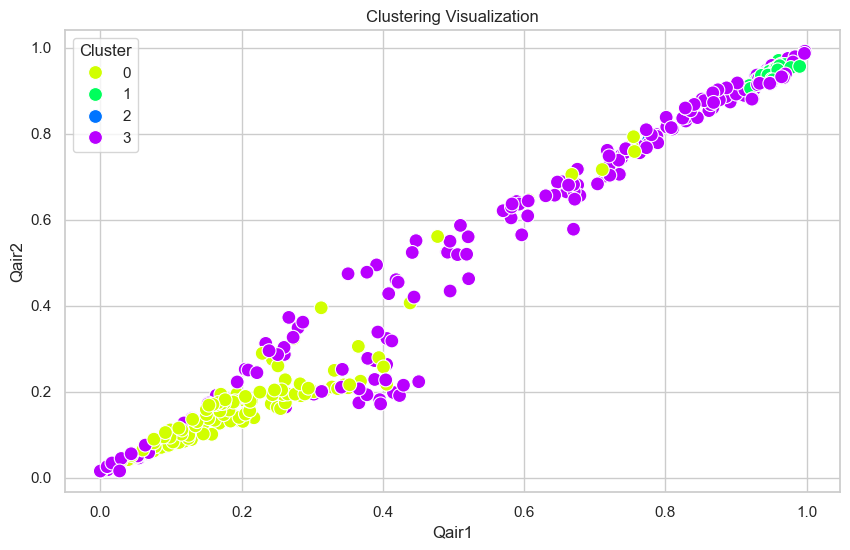

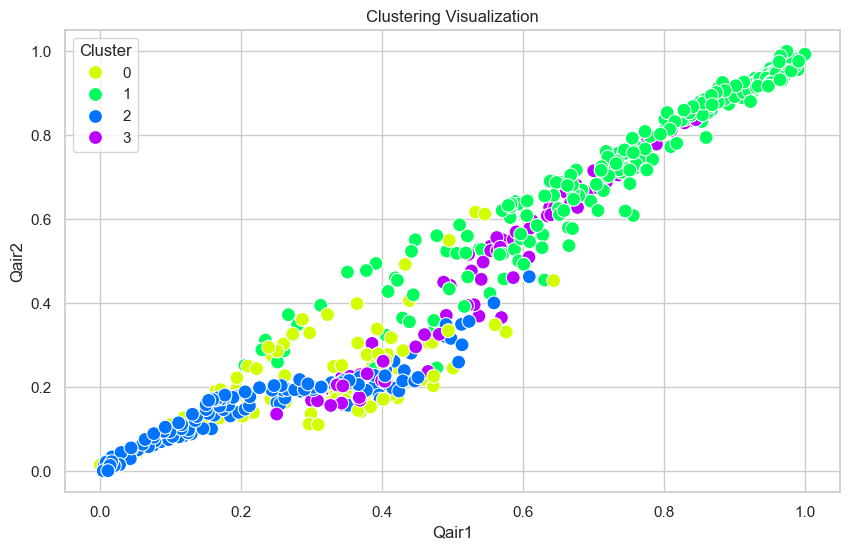

In [35]:
# db scan 
plotting(df_dbScan  , "Qair1" , "Qair2")
# clranas 
plotting(df_clarans , "Qair1" , "Qair2")

In [47]:
def plot_pca_clusters(df):
    df = df.copy()
    df = df.dropna()
    try : 
        features = df.drop(columns=['cluster', 'distance'])  # Drop non-numerical columns
    except Exception as e :
        features = df.drop(columns=['cluster', 'is_core'])
    clusters = df['cluster']

    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)

    # Create a new DataFrame for PCA results
    pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
    pca_df['cluster'] = clusters

    # Plot the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='PCA1', 
        y='PCA2', 
        hue='cluster', 
        palette='tab10', 
        data=pca_df, 
        s=100
    )
    plt.title("PCA Visualization of Clusters (2D)")
    plt.legend(title="Cluster")
    plt.show()

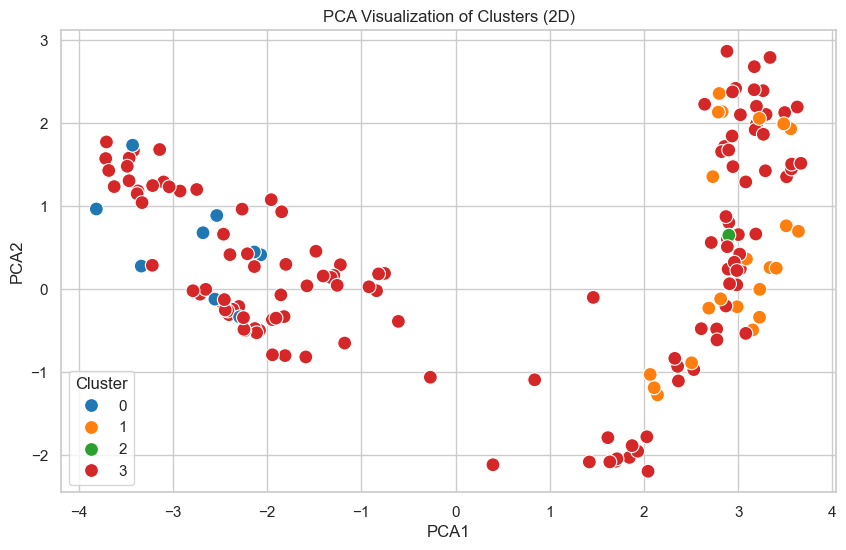

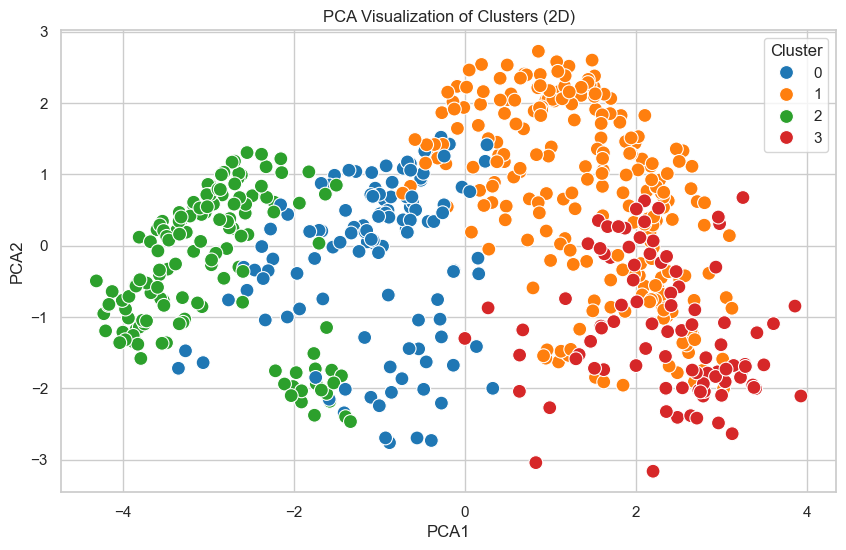

In [48]:
plot_pca_clusters(df_dbScan)
plot_pca_clusters(df_clarans)